### Load data

In [ ]:
import mne

data_path = r"data\first_try\mati\mati_test_imagery_movement_1.bdf"
raw = mne.io.read_raw_bdf(data_path, preload=True)

Extracting EDF parameters from d:\STUDIA\ZPB2\3. Data gathering\data\first_try\mati\mati_test_imagery_movement_1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 673791  =      0.000 ...   329.000 secs...


### Select only significant channels

In [32]:
raw.pick(picks=["A1", "A2", "A3", "A4", "A5", "A6", "A7", "A8", "A9", "A10", "A11", "A12", "A13", "A14", "A15", "A16"]).load_data()

<RawEDF | mati_test_imagery_movement_1.bdf, 16 x 673792 (329.0 s), ~82.3 MiB, data loaded>

### Show raw 

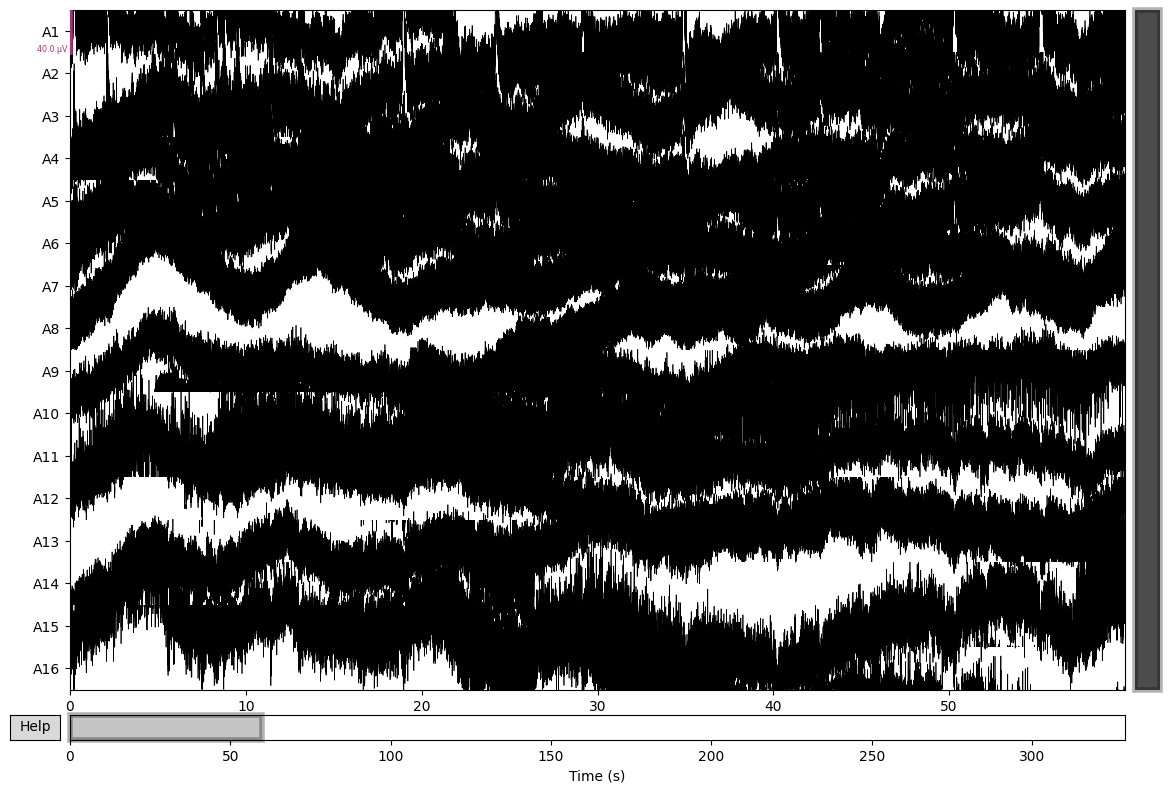

In [33]:
raw.plot(duration=60, proj=False, n_channels=len(raw.ch_names), remove_dc=True)
pass # to prevent double plotting

### Resample data, apply simple preprocessing and plot it

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge

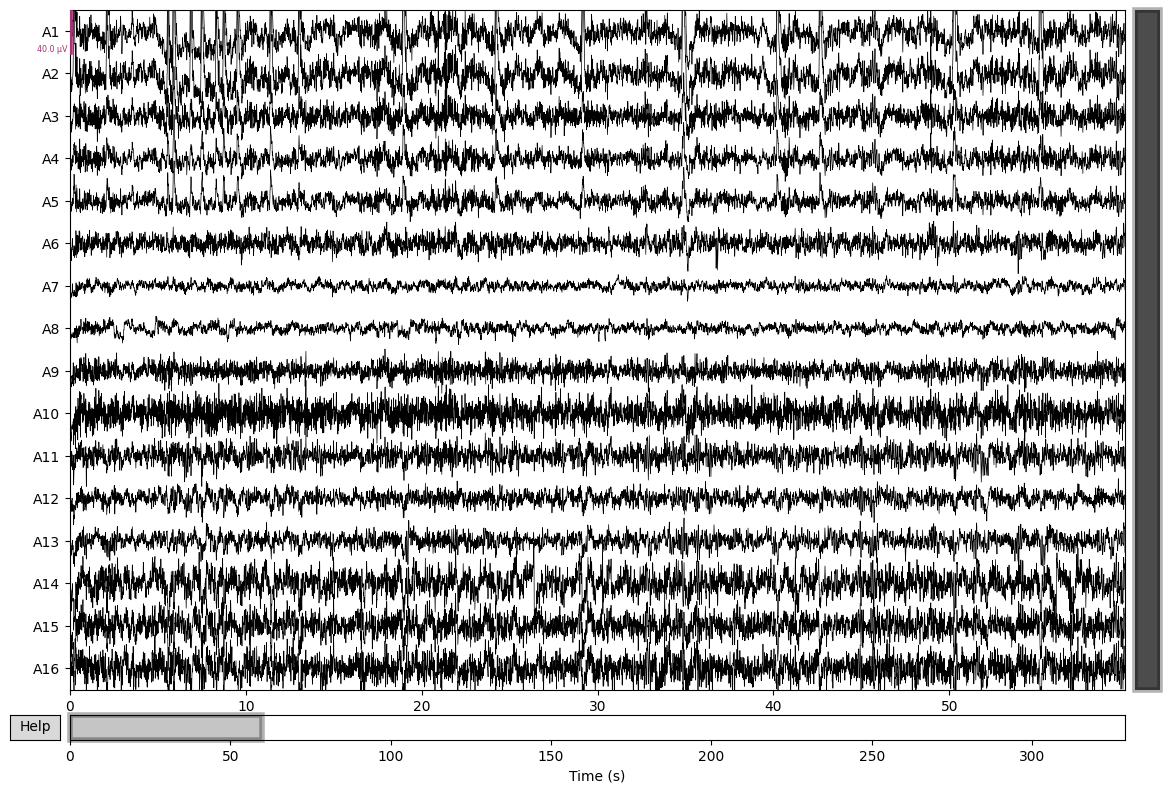

In [34]:
filtered = raw.copy().resample(sfreq=250)
filtered.filter(l_freq=1.0, h_freq=40.0, fir_design='firwin')
filtered.notch_filter(freqs=[50.0])


filtered.plot(duration=60, proj=False, n_channels=len(filtered.ch_names), remove_dc=True)
pass

Effective window size : 8.192 (s)


Plotting power spectral density (dB=True).
Effective window size : 1.000 (s)
Plotting power spectral density (dB=True).


Text(0.5, 0.98, 'Original')

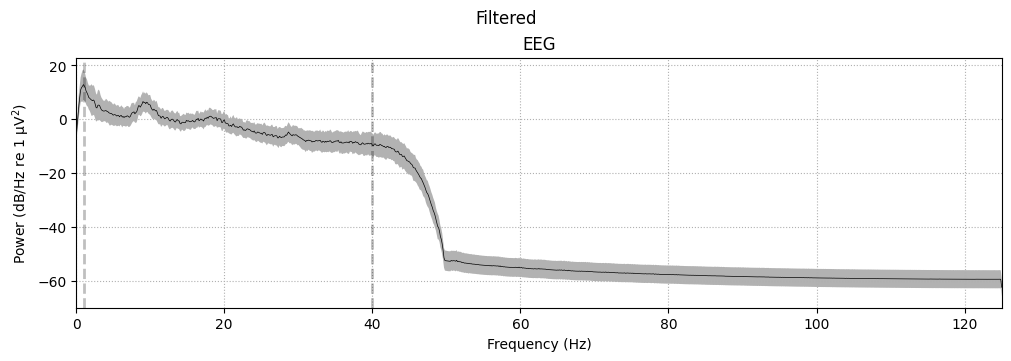

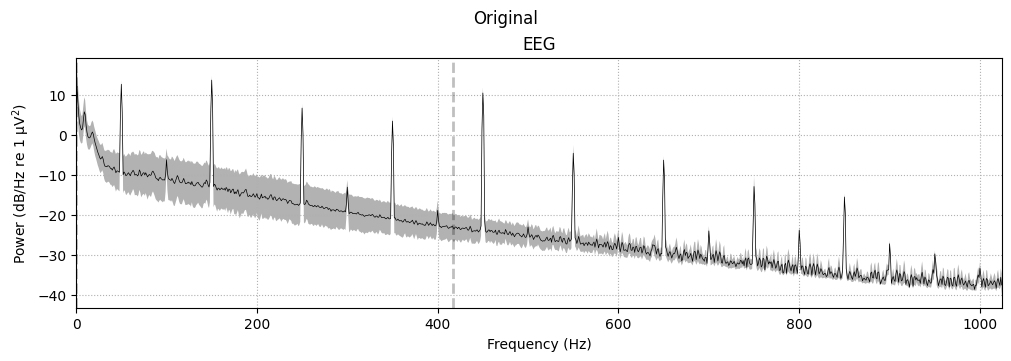

In [35]:
%matplotlib inline

fig = filtered.compute_psd().plot(average=True, picks="data", show=False)
fig.suptitle("Filtered")
fig = raw.compute_psd().plot(average=True, picks="data", show=False)
fig.suptitle("Original")

### Filtered data showcase
Original (raw) does not show up on plot because amplitude is higher than default for plot (40 microvolt)

Filtered with removed DC plot (remove_dc=True) should be the same as just filtered as 50Hz Butterworth filter was already applied  

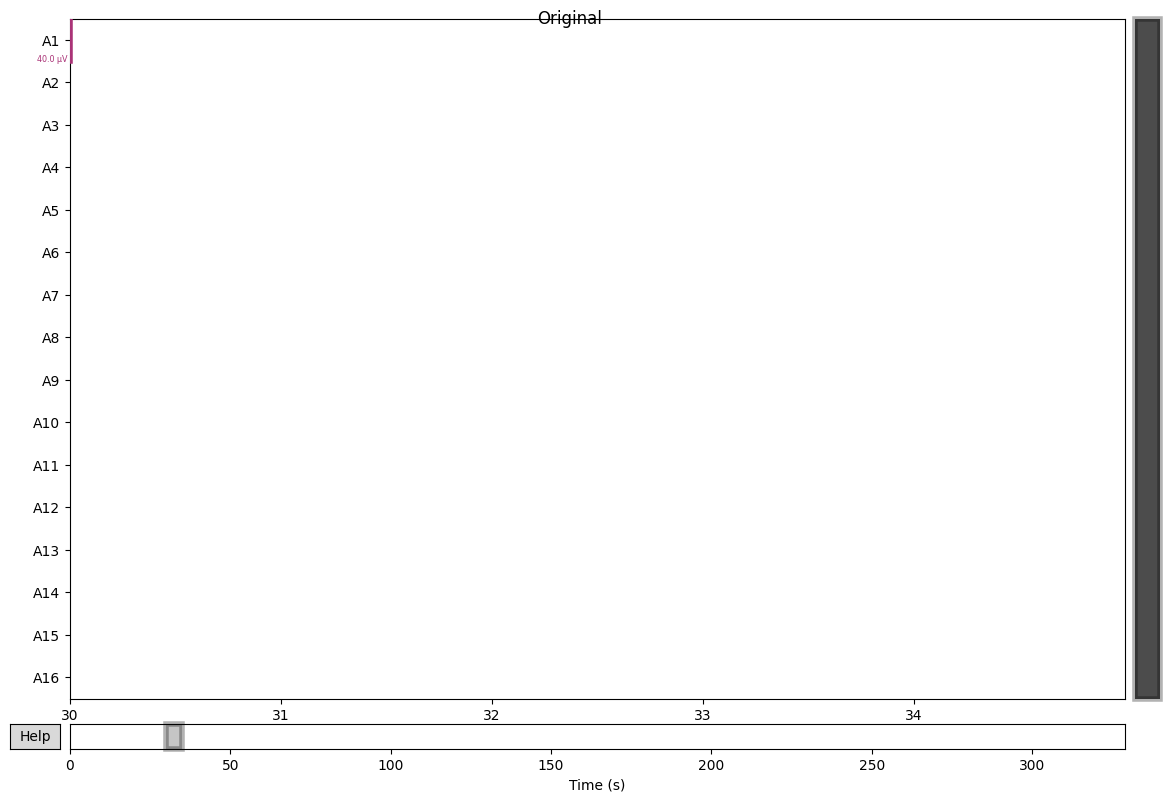

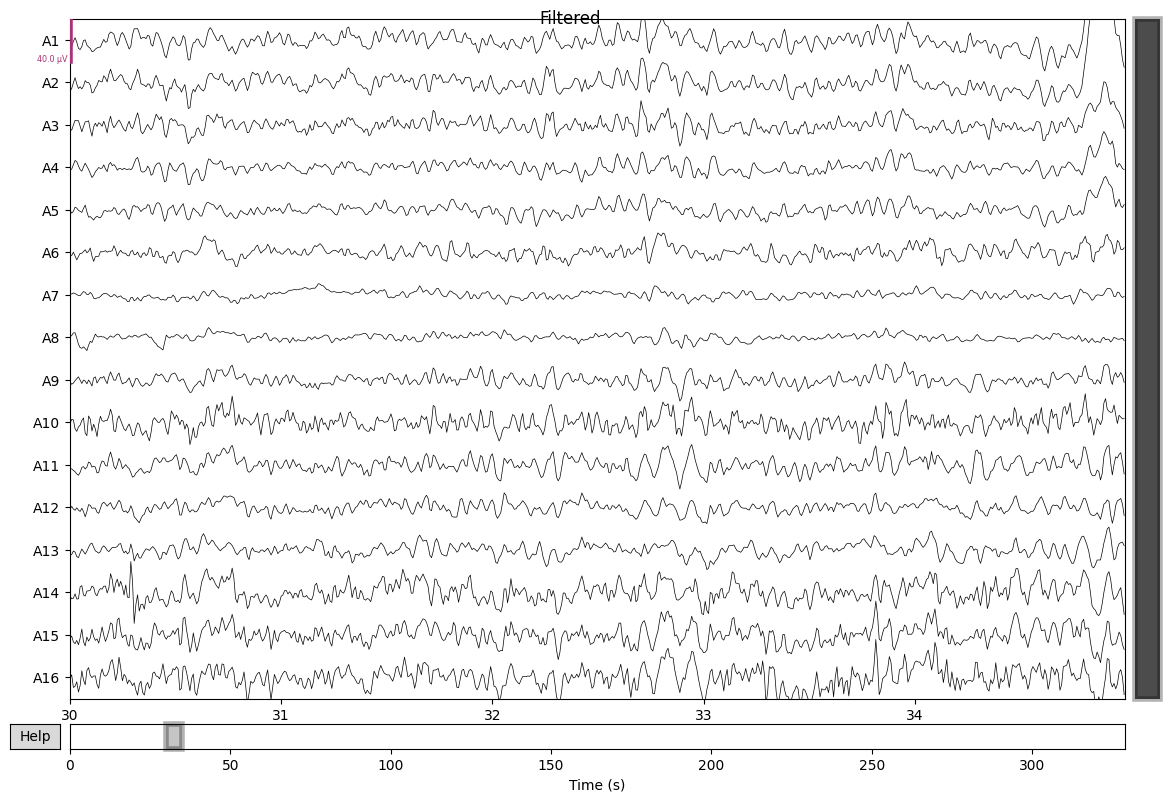

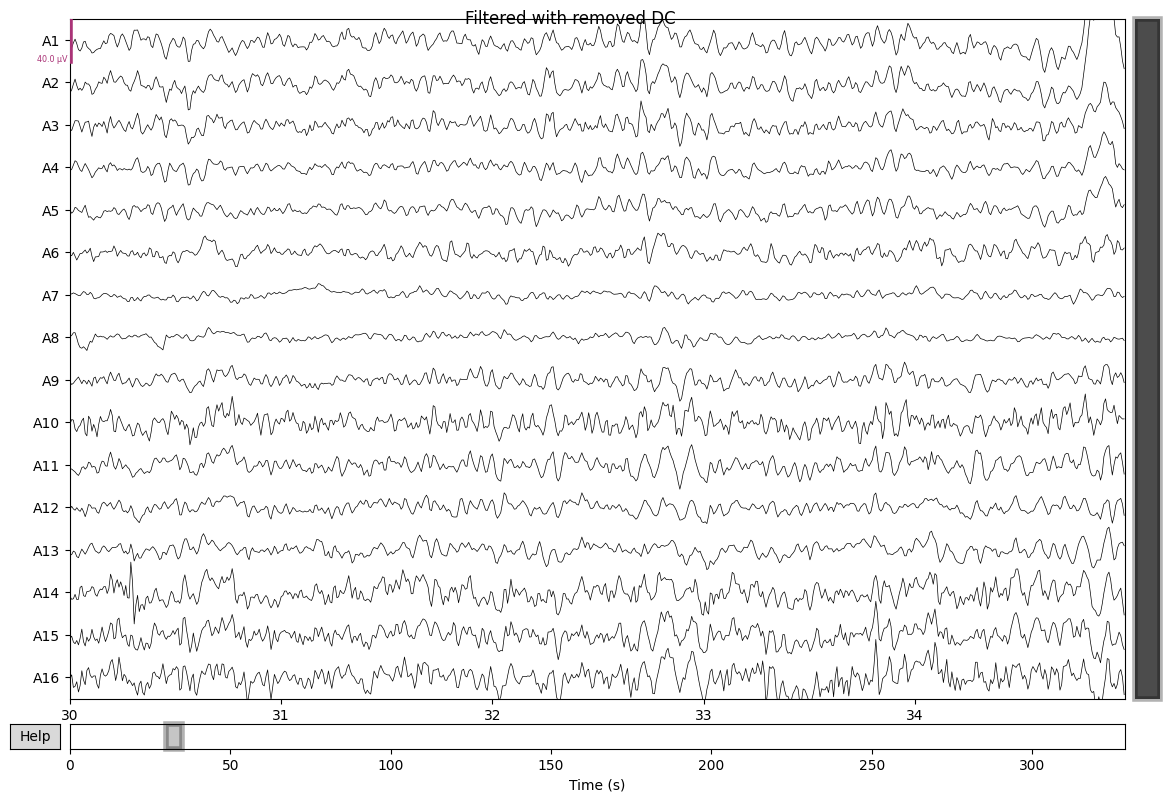

In [43]:
start = 30
duration = 5

with mne.viz.use_browser_backend("matplotlib"):
    for data, title in zip([raw, filtered], ["Original", "Filtered"]):
        fig = data.plot(start=start, duration=duration, proj=False, n_channels=len(raw.ch_names), remove_dc=False, show=False)
        fig.suptitle(title)
        if title == "Filtered":
            fig = data.plot(start=start, duration=duration, proj=False, n_channels=len(raw.ch_names), remove_dc=True, show=False)
            fig.suptitle("Filtered with removed DC")
        
